In [1]:
base = '/home3/ebrahim/what-is-brainscore/'
%load_ext autoreload
%autoreload 2

In [6]:
import numpy as np
base = '/home2/ebrahim/beyond-brainscore/'
from matplotlib import pyplot as plt
import os
from sklearn.metrics import mean_squared_error
import sys
sys.path.append('/home2/ebrahim/beyond-brainscore/')
from helper_funcs import find_best_layer
from plotting_functions import plot_across_subjects, plot_test_perf_across_layers, save_fMRI_simple, pass_info_plot_hist2d, find_rows_without_nan
from trained_results_funcs import create_pd_selected_models, find_best, max_across_selected_models
from trained_untrained_results_funcs import max_across_nested
from scipy.stats import pearsonr
import seaborn as sns
import pandas as pd
import matplotlib
from scipy.stats import ttest_rel, ttest_1samp
import nibabel as nib
from nilearn import plotting
from nilearn import surface
from nilearn import datasets
import plotly
import brainio

In [7]:
data_path = '/data/LLMs/data_processed/pereira/dataset/'
llm_acts_path = '/data/LLMs/data_processed/pereira/LLM_acts/'
results_path = '/data/LLMs/brainscore/results_pereira/trained/'
general_res_path = '/data/LLMs/brainscore/results_pereira/'
figurePath = '/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/figures/pereira_trained_updated/'
N = 10
exp = ['243', '384']
br_labels_dict = {}
num_vox_dict = {}
ytest_dict = {}
mse_intercept_dict = {}
subjects_dict = {}
for e in exp:
    bre = np.load(f'{data_path}networks_{e}.npy', allow_pickle=True)
    br_labels_dict[e] = bre
    num_vox_dict[e] = bre.shape[0]
    mse_intercept_dict[e] = np.load(f'{general_res_path}mse_intercept_{e}.npy')
    ytest_dict[e] = np.load(f'{general_res_path}y_test_ordered_{e}.npy')
    subjects_dict[e] = np.load(f"{data_path}/subjects_{e}.npy", allow_pickle=True)

In [8]:
default_palette = sns.color_palette("deep")
default_palette

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

r _lt
(64, 92540) (64, 60100)
0.1295831740116399
0.10890974775051107
0.1765588423278309
0.14216708776800271
0.08567242747732995
0.12171995408062095
Taking median value across voxels with a participant


<Figure size 640x480 with 0 Axes>

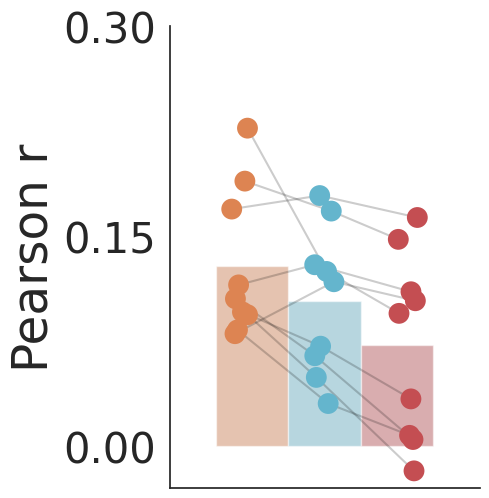

NameError: name 'yticks' is not defined

In [9]:
pearson_metric = [True, False]
sp_str_arr = ['_lt', '_sp']
linear_reg = [True, False]

for sp_str in sp_str_arr:
    for load_pearson_model in pearson_metric: 
        for lr in linear_reg:   
            
            if lr:
                lr_str = '_noL2'
                if sp_str == '_sp' or load_pearson_model == False:
                    continue 
                
            else:
                lr_str = ''
    
            if load_pearson_model:
                metric = 'r'
                clip_zero=False
                median=True
                ylabel_str = "Pearson r"
                yticks_243 = [0, 0.2, 0.4]
                yticks_384 = [0, 0.15, 0.3]
            else:
                metric = 'r2'
                clip_zero=True
                median=False
                ylabel_str = r'$R^2$'
                yticks_384 = [0, 0.05, 0.1]
                yticks_243 = [0, 0.05, 0.1]
                
            print(metric, sp_str)
            
            all_models_results_384 = np.load(f"{results_path}{metric}{sp_str}{lr_str}_384_trained.npy")
            all_models_results_243 = np.load(f"{results_path}{metric}{sp_str}{lr_str}_243_trained.npy")
            model_names = np.load(f"{results_path}rebuttal_model_names.npy")
            
            print(all_models_results_384.shape, all_models_results_243.shape)

            model_name_upper = 'GPT2-XL'

            SP_SL_word_vc_384 = max_across_selected_models(all_models_results_384, model_names, ['SENSE', 'SYNT', model_name_upper], '',  
                                            num_vox_dict, br_labels_dict, subjects_dict, exp='384', updated_model_name='SP+SL+WORD')
            SP_SL_word_LLM_vc_384 = max_across_selected_models(all_models_results_384, model_names, ['SENSE', 'SYNT'], model_name_upper,  
                                            num_vox_dict, br_labels_dict, subjects_dict, exp='384', updated_model_name=f'SP+SL+WORD+{model_name_upper}')

            SP_SL_word_vc_243 = max_across_selected_models(all_models_results_243, model_names, ['SENSE', 'SYNT', model_name_upper], '',  
                                            num_vox_dict, br_labels_dict, subjects_dict, exp='243', updated_model_name='SP+SL+WORD')
            SP_SL_word_LLM_vc_243 = max_across_selected_models(all_models_results_243, model_names, ['SENSE', 'SYNT'], model_name_upper,  
                                            num_vox_dict, br_labels_dict, subjects_dict, exp='243', updated_model_name=f'SP+SL+WORD+{model_name_upper}')


            LLM_vc_384 = max_across_selected_models(all_models_results_384, model_names, ['SP+SL', 'WORD', 'SENSE', 'SYNT'], model_name_upper,  
                                            num_vox_dict, br_labels_dict, subjects_dict, exp='384', updated_model_name=f'{model_name_upper}')

            LLM_vc_243 = max_across_selected_models(all_models_results_243, model_names, ['SP+SL', 'WORD', 'SENSE', 'SYNT'], model_name_upper,  
                                            num_vox_dict, br_labels_dict, subjects_dict, exp='243', updated_model_name=f'{model_name_upper}')


            modified_384 = pd.concat((SP_SL_word_vc_384, SP_SL_word_LLM_vc_384, LLM_vc_384))
            modified_243 = pd.concat((SP_SL_word_vc_243, SP_SL_word_LLM_vc_243, LLM_vc_243))

            _, _, _ = plot_across_subjects(modified_384.copy(), figurePath=figurePath, selected_networks=['language'],
                                                        saveName=f"GPT2-XL_SP+SL+WORD_{metric}{sp_str}{lr_str}_384", hue_order=['SP+SL+WORD', f'SP+SL+WORD+{model_name_upper}', model_name_upper], 
                                                        yticks=yticks_384, order=['language'], clip_zero=clip_zero, color_palette=[default_palette[1], default_palette[9], default_palette[3]], 
                                                        draw_lines=True, ms=15, plot_legend=False, 
                                                        plot_legend_under=False, width=0.7, median=median, ylabel_str=ylabel_str)

            _, _, _ = plot_across_subjects(modified_243.copy(), figurePath=figurePath, selected_networks=['language'],
                                                        saveName=f"GPT2-XL_SP+SL+WORD_{metric}{sp_str}{lr_str}_243", hue_order=['SP+SL+WORD', f'SP+SL+WORD+{model_name_upper}', model_name_upper], 
                                                        yticks=yticks_243, order=['language'], clip_zero=clip_zero, color_palette=[default_palette[1], default_palette[9], default_palette[3]], 
                                                        draw_lines=True, ms=15, plot_legend=False, 
                                                        plot_legend_under=False, width=0.7, median=median, ylabel_str=ylabel_str)

r _lt
(64, 92540) (64, 60100)
0.1295831740116399
0.10890974775051107
0.1765588423278309
0.14216708776800271
0.08567242747732995
0.12171995408062095
Taking median value across voxels with a participant


<Figure size 640x480 with 0 Axes>

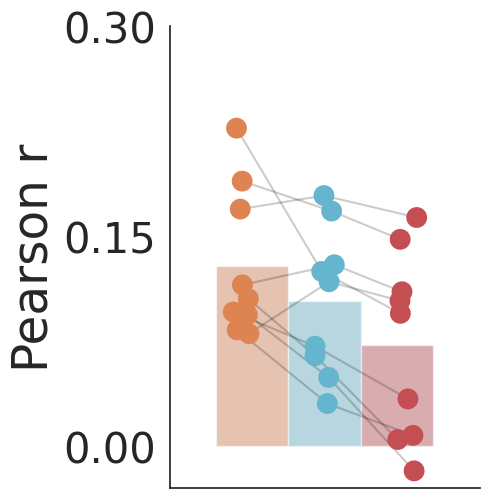

Taking median value across voxels with a participant


<Figure size 640x480 with 0 Axes>

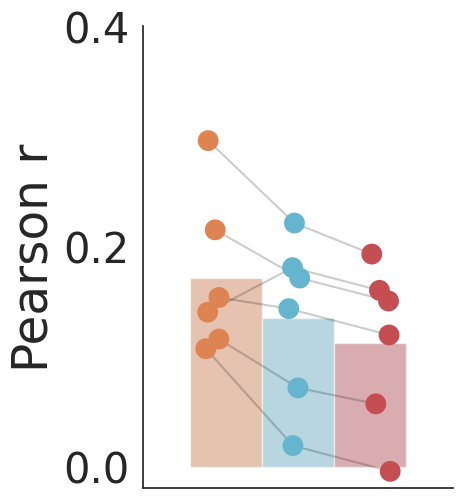

r _lt
(64, 92540) (64, 60100)
0.1542795460659728
0.17567932678748174
0.2018097743012293
0.21101520971074614
0.16602014878868673
0.1908015357403563
Taking median value across voxels with a participant


<Figure size 640x480 with 0 Axes>

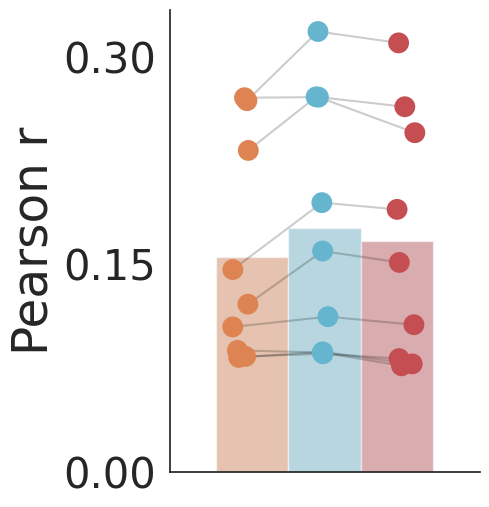

Taking median value across voxels with a participant


<Figure size 640x480 with 0 Axes>

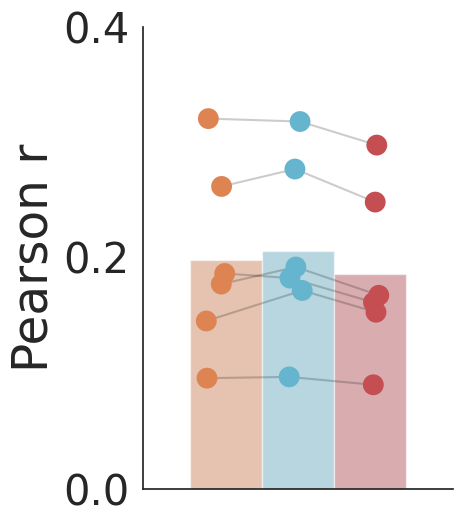

r2 _lt
(64, 92540) (64, 60100)
0.028536882767267242
0.037792360361150426
0.04783230970103018
0.050363863409620936
0.03446433447484335
0.041313514249447285


<Figure size 640x480 with 0 Axes>

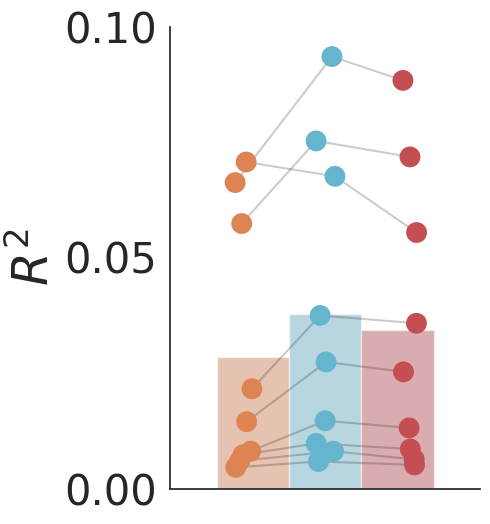

<Figure size 640x480 with 0 Axes>

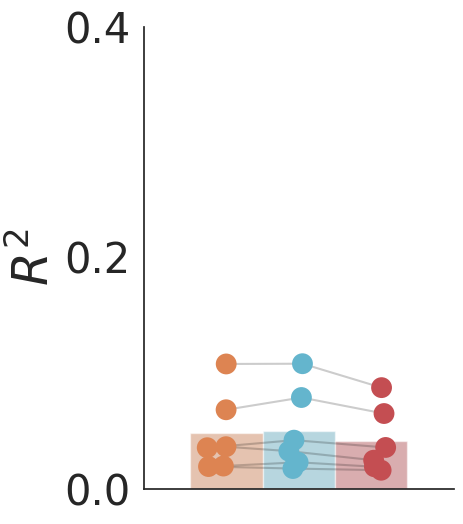

r _sp
(64, 92540) (64, 60100)
0.1542795460659728
0.17104074623511575
0.2018097743012293
0.21578716574222342
0.16420112251039123
0.20307517441805878
Taking median value across voxels with a participant


<Figure size 640x480 with 0 Axes>

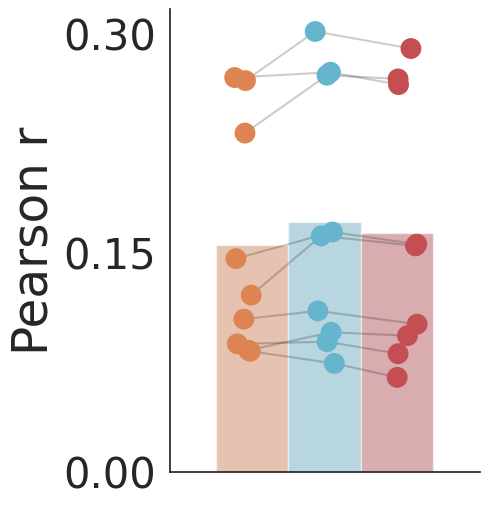

Taking median value across voxels with a participant


<Figure size 640x480 with 0 Axes>

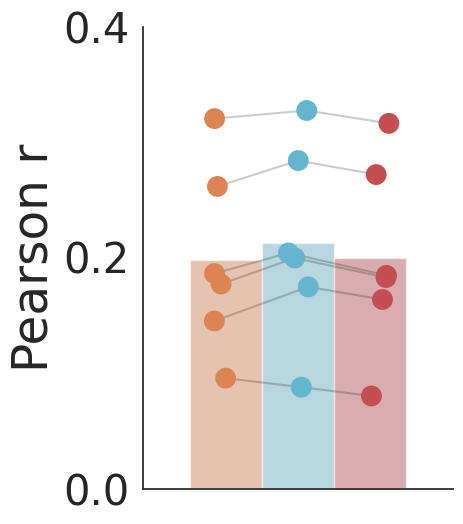

r2 _sp
(64, 92540) (64, 60100)
0.028536882767267242
0.036179300135776304
0.04783230970103018
0.05280346613835224
0.03379017075176255
0.046989760688681055


<Figure size 640x480 with 0 Axes>

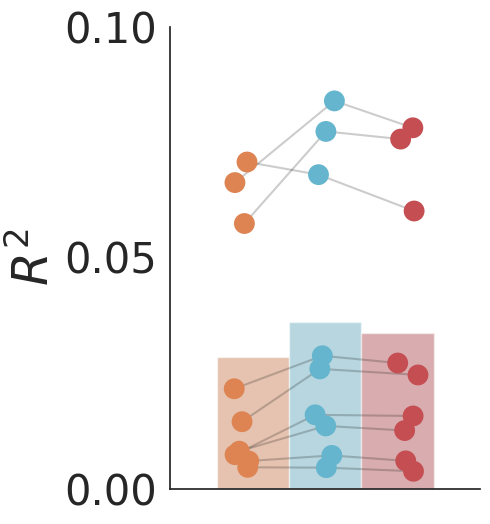

<Figure size 640x480 with 0 Axes>

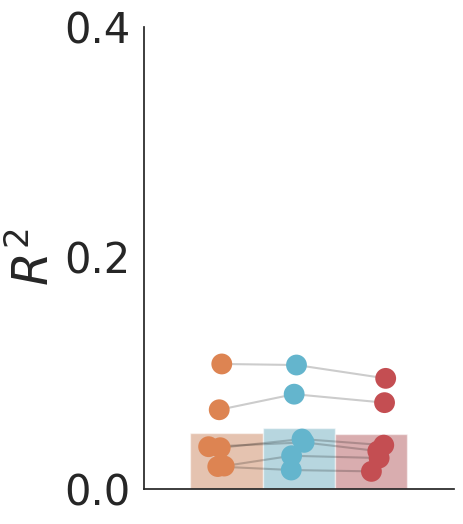

In [16]:
pearson_metric = [True, False]
sp_str_arr = ['_lt', '_sp']
linear_reg = [True, False]

for sp_str in sp_str_arr:
    for load_pearson_model in pearson_metric: 
        for lr in linear_reg:   
            
            if lr:
                lr_str = '_noL2'
                if sp_str == '_sp' or load_pearson_model == False:
                    continue 
                
            else:
                lr_str = ''
    
            if load_pearson_model:
                metric = 'r'
                clip_zero=False
                median=True
                ylabel_str = "Pearson r"
                yticks_243 = [0, 0.2, 0.4]
                yticks_384 = [0, 0.15, 0.3]
            else:
                metric = 'r2'
                clip_zero=True
                median=False
                ylabel_str = r'$R^2$'
                yticks_384 = [0, 0.05, 0.1]
                yticks_243 = [0, 0.05, 0.1]
                
            print(metric, sp_str)
            
            all_models_results_384 = np.load(f"{results_path}{metric}{sp_str}{lr_str}_384_trained.npy")
            all_models_results_243 = np.load(f"{results_path}{metric}{sp_str}{lr_str}_243_trained.npy")
            model_names = np.load(f"{results_path}rebuttal_model_names.npy")
            
            print(all_models_results_384.shape, all_models_results_243.shape)

            model_name_upper = 'GPT2-XL'

            SP_SL_word_vc_384 = max_across_selected_models(all_models_results_384, model_names, ['SENSE', 'SYNT', model_name_upper], '',  
                                            num_vox_dict, br_labels_dict, subjects_dict, exp='384', updated_model_name='SP+SL+WORD')
            SP_SL_word_LLM_vc_384 = max_across_selected_models(all_models_results_384, model_names, ['SENSE', 'SYNT'], model_name_upper,  
                                            num_vox_dict, br_labels_dict, subjects_dict, exp='384', updated_model_name=f'SP+SL+WORD+{model_name_upper}')

            SP_SL_word_vc_243 = max_across_selected_models(all_models_results_243, model_names, ['SENSE', 'SYNT', model_name_upper], '',  
                                            num_vox_dict, br_labels_dict, subjects_dict, exp='243', updated_model_name='SP+SL+WORD')
            SP_SL_word_LLM_vc_243 = max_across_selected_models(all_models_results_243, model_names, ['SENSE', 'SYNT'], model_name_upper,  
                                            num_vox_dict, br_labels_dict, subjects_dict, exp='243', updated_model_name=f'SP+SL+WORD+{model_name_upper}')


            LLM_vc_384 = max_across_selected_models(all_models_results_384, model_names, ['SP+SL', 'WORD', 'SENSE', 'SYNT'], model_name_upper,  
                                            num_vox_dict, br_labels_dict, subjects_dict, exp='384', updated_model_name=f'{model_name_upper}')

            LLM_vc_243 = max_across_selected_models(all_models_results_243, model_names, ['SP+SL', 'WORD', 'SENSE', 'SYNT'], model_name_upper,  
                                            num_vox_dict, br_labels_dict, subjects_dict, exp='243', updated_model_name=f'{model_name_upper}')


            modified_384 = pd.concat((SP_SL_word_vc_384, SP_SL_word_LLM_vc_384, LLM_vc_384))
            modified_243 = pd.concat((SP_SL_word_vc_243, SP_SL_word_LLM_vc_243, LLM_vc_243))

            _, _, _ = plot_across_subjects(modified_384.copy(), figurePath=figurePath, selected_networks=['language'],
                                                        saveName=f"GPT2-XL_SP+SL+WORD_{metric}{sp_str}{lr_str}_384", hue_order=['SP+SL+WORD', f'SP+SL+WORD+{model_name_upper}', model_name_upper], 
                                                        yticks=yticks_384, order=['language'], clip_zero=clip_zero, color_palette=[default_palette[1], default_palette[9], default_palette[3]], 
                                                        draw_lines=True, ms=15, plot_legend=False, 
                                                        plot_legend_under=False, width=0.7, median=median, ylabel_str=ylabel_str)

            _, _, _ = plot_across_subjects(modified_243.copy(), figurePath=figurePath, selected_networks=['language'],
                                                        saveName=f"GPT2-XL_SP+SL+WORD_{metric}{sp_str}{lr_str}_243", hue_order=['SP+SL+WORD', f'SP+SL+WORD+{model_name_upper}', model_name_upper], 
                                                        yticks=yticks, order=['language'], clip_zero=clip_zero, color_palette=[default_palette[1], default_palette[9], default_palette[3]], 
                                                        draw_lines=True, ms=15, plot_legend=False, 
                                                        plot_legend_under=False, width=0.7, median=median, ylabel_str=ylabel_str)